# Tratamiento de datos COVID-10
## Objeto
Se tratarán los datos de la [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19) que se traem al directorio $data_dir. 

Se utilizarán tablas de población para, en el futuro, obtener información más relevante

## Obtención de datos
Se obtienen los datos de población desde los repositorios de Naciones Unidas.

Los datos de contagios y fallecidos por COVID-19 se traen del repositorio mantenido por la Universidad Johns Hopkins

In [25]:
data_dir = './data'
covid_dir = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series'
covid_git_url = 'https://github.com/CSSEGISandData/COVID-19'
population_file = 'WPP2019_PopulationByAgeSex_Medium.csv'
covid_confirmed_file = 'time_series_covid19_confirmed_global.csv'
covid_deaths_file = 'time_series_covid19_deaths_global.csv'
un_pop_repo_url = 'https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/' + population_file
covid_owid_dir = 'covid-19-data'
covid_owid_url = 'https://github.com/owid/covid-19-data.git'
covid_owid_vaccinations_file = 'public/data/vaccinations/vaccinations.csv'

! if [ ! -d '{data_dir}' ]; then echo 'No existe directorio de datos. Creándolo...'; mkdir '{data_dir}' ; fi
! if [ ! -d '{data_dir}/{covid_dir}' ]; then echo 'No existe clone del repositorio {covid_dir}. Ejecutando git clone {covid_git_url}'; cd '{data_dir}';  git clone '{covid_git_url}'; fi
! if [ ! -d "{data_dir}/{covid_owid_dir}" ]; then echo 'No existe clone del repositorio {covid_owid_dir}. Ejecutando git clone {covid_owid_url}'; cd '{data_dir}';  git clone '{covid_owid_url}'; fi
! if [ ! -f '{data_dir}/{population_file}' ]; then echo 'No existen datos de población Trayéndolos de {un_pop_repo_url}'; cd '{data_dir}'; curl -g '{un_pop_repo_url}' -o $population_file; fi

## Actualización de ficheros

In [26]:
! cd '{data_dir}/{covid_dir}'; git pull
! ls -l '{data_dir}/{covid_dir}/'

remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 32 (delta 22), reused 30 (delta 21), pack-reused 0
Unpacking objects: 100% (32/32), 91.75 KiB | 181.00 KiB/s, done.
From https://github.com/CSSEGISandData/COVID-19
   47894a0bc..af8b8b348  master     -> origin/master
 * [new branch]          automated-patch-for-delayed-data-for-US-01-29-2021 -> origin/automated-patch-for-delayed-data-for-US-01-29-2021
   8df5760e6..8b64693a4  web-data   -> origin/web-data
Updating 47894a0bc..af8b8b348
Fast-forward
 .../csse_covid_19_daily_reports/01-29-2021.csv     |  78 +--
 .../csse_covid_19_daily_reports_us/01-29-2021.csv  |   2 +-
 .../time_series_covid19_confirmed_US.csv           | 640 ++++++++++-----------
 .../time_series_covid19_confirmed_global.csv       |   2 +-
 .../time_series_covid19_deaths_US.csv              | 634 ++++++++++----------
 .../time_series_covid19_deaths_global.csv          |   2

In [27]:
! cd '{data_dir}/{covid_owid_dir}'; git pull
! ls -l '{data_dir}/{covid_owid_dir}/'

remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 164 (delta 126), reused 153 (delta 126), pack-reused 10
Receiving objects: 100% (164/164), 10.10 MiB | 2.57 MiB/s, done.
Resolving deltas: 100% (126/126), completed with 79 local objects.
From https://github.com/owid/covid-19-data
   aeb95aa0..478052d8  master     -> origin/master
Updating aeb95aa0..478052d8
Fast-forward
 .../jhu/COVID-19 - Johns Hopkins University.csv    |  14 +-
 public/data/jhu/biweekly_cases.csv                 |   2 +-
 public/data/jhu/biweekly_cases_per_million.csv     |   2 +-
 public/data/jhu/biweekly_deaths.csv                |   2 +-
 public/data/jhu/biweekly_deaths_per_million.csv    |   2 +-
 public/data/jhu/full_data.csv                      |   4 +-
 public/data/jhu/new_cases.csv                      |   2 +-
 public/data/jhu/new_cases_per_million.csv          |   2 +-
 public/data/jhu/new_deaths.csv       

## Importación de datos
Lo primero es común a todos los programas que traten datos

In [28]:
%matplotlib inline
import pandas as pd
import numpy as np

Se utiliza Pandas para leer el fichero csv. Las columnas que notienen datos (las 4 primeras), se ponen de índice. 

Se van a leer los datos de fallecimientos y de casso confirmados

In [29]:
deaths = pd.read_csv(data_dir + '/' + covid_dir + '/' + covid_deaths_file, 
                      index_col=[0,1,2,3])
confirmed = pd.read_csv(data_dir + '/' + covid_dir + '/' + covid_confirmed_file, 
                           index_col=[0,1,2,3])
population = pd.read_csv (data_dir + '/' + population_file)
vaccinations = pd.read_csv (data_dir + '/' + covid_owid_dir + '/' + covid_owid_vaccinations_file, 
                            usecols=['location', 'date',
                                     'people_vaccinated_per_hundred',
                                     'people_fully_vaccinated_per_hundred'], 
                            parse_dates=['date'])


## Tratamiento de datos
Se filtran los datos de población para suprimir la división por edades y quedarnos con los del año 2021. 
Se conserva la división por género por si tuviese interés

In [30]:
pop_filtered = population[(population['VarID'] == 2) & (population['Time'] == 2021) ] \
                         [['Location','PopMale','PopFemale','PopTotal']] \
                         .groupby(['Location']).sum()

#population.head()
#pop_filtered.index.names

pop_filtered.loc['Spain']
pop_filtered.head(3)

,PopMale,PopFemale,PopTotal
Location,,,
Afghanistan,20434.981,19400.447,39835.428
Africa,686414.950,687071.522,1373486.472
African Group,685518.459,686168.843,1371687.302


Se cambia el nombre de algunos índices. Se ha visto que el nombre de los países es distinto en las tablas de la 
ONU que en las tablas COVID. Por ejemplo, los **Estados Unidos de América** aparecen en las tablas de la ONU
como **United States of America**, mientras que en las tablas COVID como **US**. El diccionario **change_dict**
está pensado para todos estos casos.

In [31]:
change_pop_dict = {
    'United States of America': 'US',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Russian Federation': 'Russia',
    'China, Taiwan Province of China': 'Taiwan*'
              }

pop_index_list = pop_filtered.index.tolist()

for country in change_pop_dict:
    pop_index_list[pop_index_list.index(country)] = change_pop_dict[country]

pop_filtered.index = pop_index_list

In [32]:
pop_filtered.loc[['US',
                  'Spain',
                  'Portugal',
                  'Morocco',
                  'United Kingdom',
                  'Ireland',
                  'Italy',
                  'Germany',
                  'France',
                  'Argentina',
                  'Chile',
                  'Mexico',
                  'Peru',
                  'Colombia', 
                  'Venezuela', 
                  'Cuba', 
                  'Bolivia', 
                  'Ecuador', 
                  'Guatemala', 
                  'Panama', 
                  'Costa Rica',
                  'Russia',
                  'China',
                  'Taiwan*',
                  'Belgium',
                  'Netherlands',
                  'Australia']].sort_values('PopTotal', ascending=False)

,PopMale,PopFemale,PopTotal
China,740521.760,703694.342,1444216.102
US,164729.431,168185.643,332915.074
Russia,67638.243,78273.779,145912.022
Mexico,63724.708,66537.512,130262.220
Germany,41500.151,42400.320,83900.471
United Kingdom,33716.291,34490.823,68207.114
France,31662.586,33763.591,65426.177
Italy,29411.239,30956.232,60367.471
Colombia,25171.408,26094.433,51265.841
Spain,22979.101,23766.110,46745.211


Se obtienen los dataframes de incrementos por población

In [33]:
deaths_sum = deaths.groupby(level=1).sum()
confirmed_sum = confirmed.groupby(level=1).sum()


def get_by_pop_inc_df (df,pop):
    df_by_pop_inc = df.divide(pop_filtered['PopTotal']/(pop/1000), axis=0).transpose().diff()
    df_by_pop_inc.index = pd.to_datetime(df_by_pop_inc.index)
    return df_by_pop_inc
    
confirmed_factor = 100000
deaths_factor = 10000000
confirmed_sum_by_pop_inc = get_by_pop_inc_df(confirmed_sum,confirmed_factor)
deaths_sum_by_pop_inc = get_by_pop_inc_df(deaths_sum,deaths_factor)



confirmed_sum_by_pop_inc.head(3)
#confirmed_100K = confirmed_sum.loc['Spain'].diff() / (pop_filtered.loc['Spain']['PopTotal'] /100)
#confirmed_100K.rolling(min_periods=1, window=7).sum().tail(35)

,Afghanistan,Africa,African Group,African Union,African Union: Central Africa,African Union: Eastern Africa,African Union: Northern Africa,African Union: Southern Africa,African Union: Western Africa,"African, Caribbean and Pacific (ACP) Group of States",...,Western Africa,Western Asia,Western Europe,Western European and Others Group (WEOG),Western Sahara,World,World Bank Regional Groups (developing only),Yemen,Zambia,Zimbabwe
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-01-24,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


Vacunaciones

In [34]:
vac_grouped = vaccinations.groupby('location')

suffixes = {
    'people_vaccinated_per_hundred': ' people',
    'people_fully_vaccinated_per_hundred': ' fully'
}

# Creamos un nuevo dataframe iterando sobre todos los países en grouped,
# añadiendo, para cada país, tantas columnas como líneas hay en el diccionario
# suffixes utilizando, en lugar del nombre de la clave, el del país seguido por
# el sufijo correspondiente.

vc_df = pd.DataFrame()

for country in vac_grouped.groups.keys():
    vacgr_df = vac_grouped.get_group(country).set_index('date')
    
    for item in suffixes.keys():
        vc_df[country + suffixes[item]] = vacgr_df[item]
        
# Utilizamos los nombres de países de la Johns Hopkins.
# Creamos, para ello, un diccionario que traduce el nombre del país en los datos
# de vacunaciones al nombre en los datos de la Johns Hopkins

change_vac_countries = {
    'United States': 'US'
}

change_vac_dict = {}
for k in change_vac_countries.keys():
    for suffix in suffixes.values():
        change_vac_dict[k + suffix] = change_vac_countries[k] + suffix

vc_df.rename(columns=change_vac_dict, inplace=True)

vc_df.fillna(method='ffill',inplace=True)

#vc_df.fillna(0.0, inplace=True)

vc_df [['US people', 'US fully', 'Spain people', 'Spain fully']]

,US people,US fully,Spain people,Spain fully
date,,,,
2020-12-29,NaN,NaN,NaN,NaN
2020-12-30,0.84,NaN,NaN,NaN
2020-12-31,0.84,NaN,NaN,NaN
2021-01-01,0.84,NaN,NaN,NaN
2021-01-02,1.28,NaN,NaN,NaN
2021-01-03,1.28,NaN,NaN,NaN
2021-01-04,1.38,NaN,0.18,NaN
2021-01-05,1.46,NaN,0.30,NaN
2021-01-06,1.60,NaN,0.30,NaN


## Gráficos

Se obtienen gráficos para fallecimientos y casos confirmados utilizando ventanas deslizantes de
longitud variable (**confirmed_window** y **deaths_window**) para casos confirmados y fallecimientos.
Se ha comprobadoque los datos presentan fuerte correlación con el día de la semana. Por elllo,
Cualquier longitud de ventana que no sea múltiplo de 7 causa dientes de sierra.

Los países para los cuales se desean los gráficos están en el array **interesting_countries**.

El último dato es el de la fecha en la que se ejecuta el notebook (**todate = today**). El primero de 
los datos es el de hace **nweeks** (configurable) semanas.

La escala en y puede ser logarítimca (**logaritmic = True**) o no (**logaritmic = False**).

El tamaño del gráfico se configura con **fsize**. Se trata de una dupla en el que el primer
componente es el tamaño del eje x y el segundo el del eje y.

Los primeros gráficos son comparativos entre países. Permiten ver la evolución de la enfermedad
en distintos entornos

<AxesSubplot:title={'center':'Fallecimientos en últimos 7.0 días por 10000000 de habitantes'}>

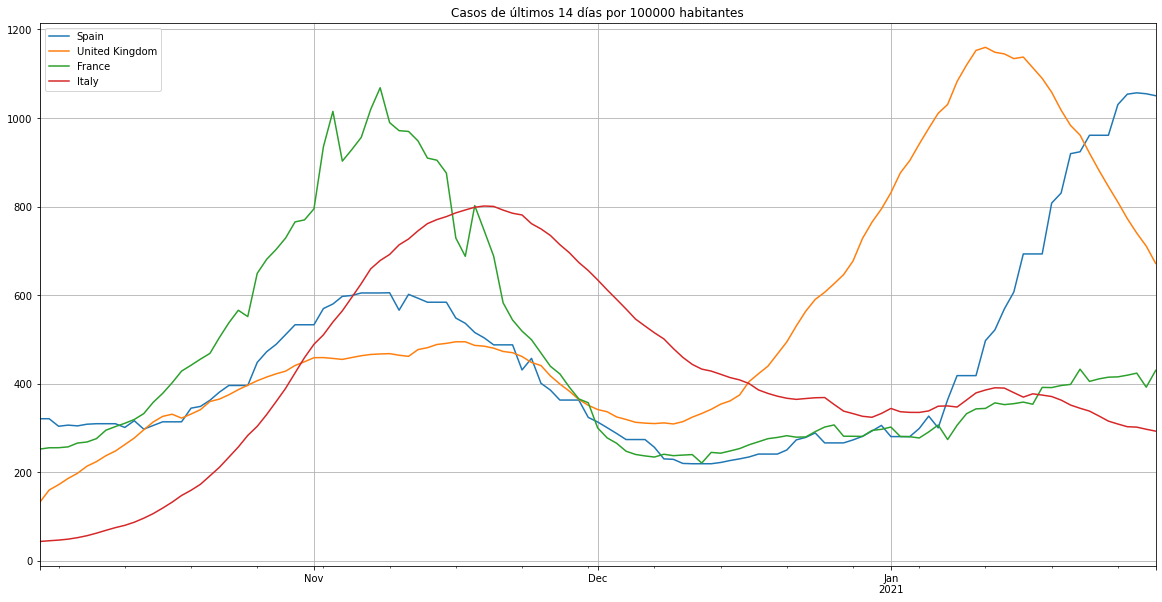

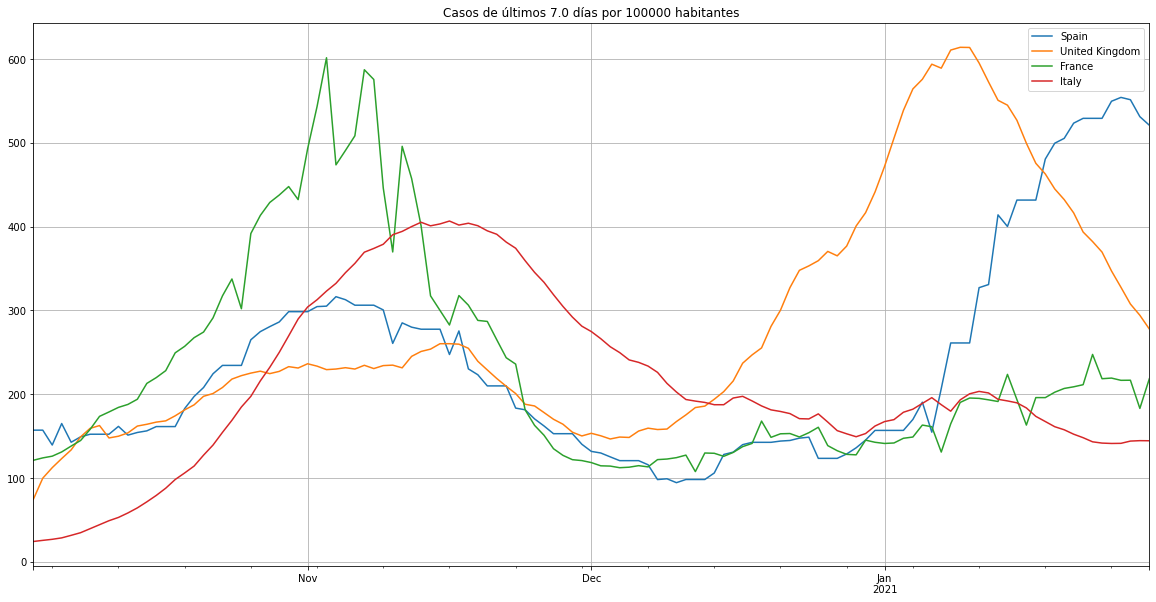

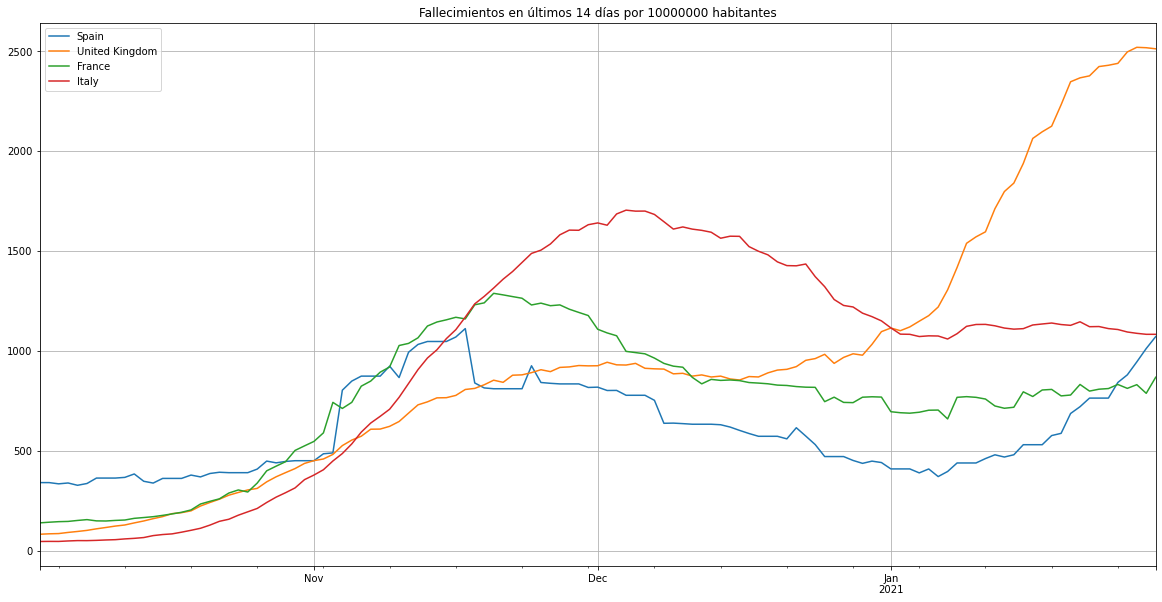

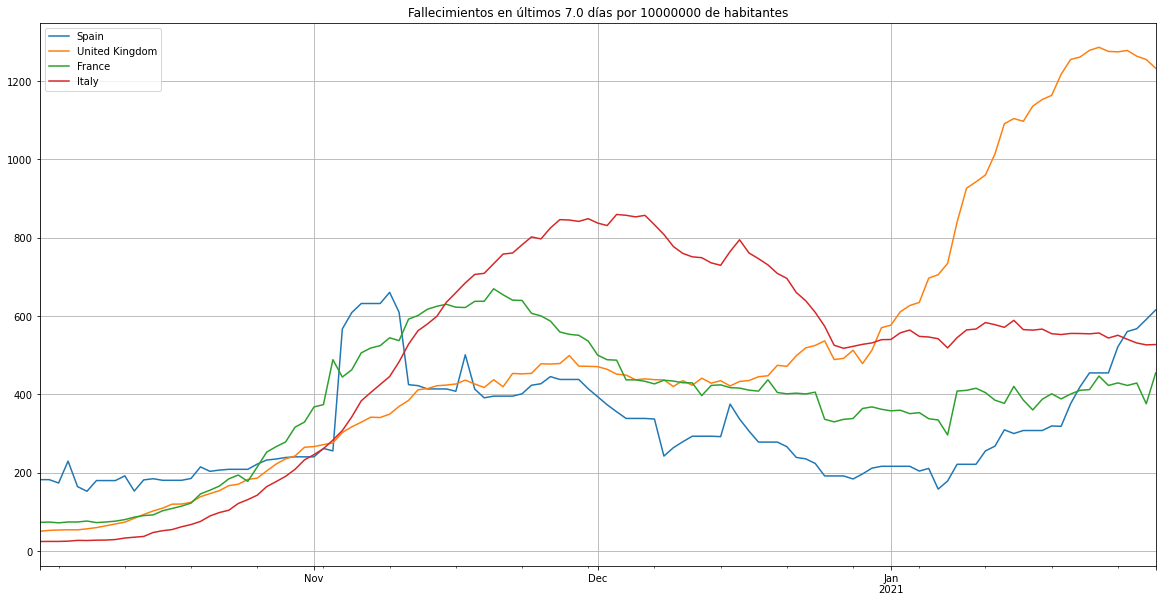

In [35]:
import datetime

nweeks=15
interesting_countries = [
                         'Spain',
                         'United Kingdom', 
                         #'Ireland', 
                         #'Portugal',  
                         #'Israel',
                         'France',
                         #'Germany',
                         'Italy',
                         #'Netherlands',
                         #'Belgium',
                         #'Sweden',
                         #'US'
                        ]

today = datetime.date.today()
#yesterday = today - datetime.timedelta(days=1)
fsize=(20,10)
logaritmic = False
confirmed_window = 14
deaths_window = 14
fromdate=today - datetime.timedelta(weeks=nweeks, days=max(confirmed_window, deaths_window))
fromdate_df = fromdate - datetime.timedelta(days=max(confirmed_window, deaths_window))
todate=today

cw_df = confirmed_sum_by_pop_inc[fromdate_df:todate].rolling(min_periods=1, window=confirmed_window).sum()[interesting_countries]
cw_df[fromdate:todate].plot(
                            title='Casos de últimos {} días por {} habitantes'.format(confirmed_window, confirmed_factor), 
                            figsize=fsize, 
                            logy=logaritmic,
                            grid=True
                           )

cw2_df = confirmed_sum_by_pop_inc[fromdate_df:todate].rolling(min_periods=1, window=int(confirmed_window/2)).sum()[interesting_countries]
cw2_df[fromdate:todate].plot(
                             title='Casos de últimos {} días por {} habitantes'.format(confirmed_window/2, confirmed_factor), 
                             figsize=fsize, 
                             logy=logaritmic,
                             grid=True
                            )
dw_df = deaths_sum_by_pop_inc[fromdate_df:todate].rolling(min_periods=1, window=deaths_window).sum()[interesting_countries]
dw_df[fromdate:todate].plot(
                            title='Fallecimientos en últimos {} días por {} habitantes'.format(deaths_window, deaths_factor), 
                            figsize=fsize, 
                            logy=logaritmic,
                            grid=True
                           )
dw2_df = deaths_sum_by_pop_inc[fromdate_df:todate].rolling(min_periods=1, window=int(deaths_window/2)).sum()[interesting_countries]
dw2_df[fromdate:todate].plot(
                             title='Fallecimientos en últimos {} días por {} de habitantes'.format(deaths_window/2, deaths_factor), 
                             figsize=fsize, 
                             logy=logaritmic,
                             grid=True
                            )

Curvas de vacunación

<AxesSubplot:title={'center':'Vacunaciones (%)'}, xlabel='date'>

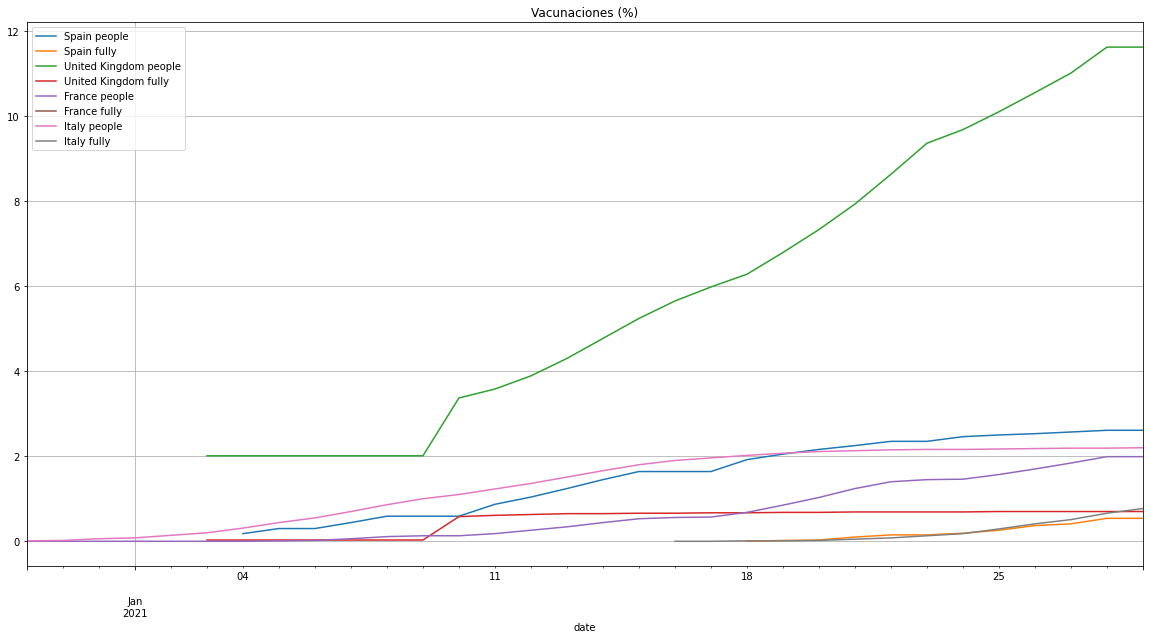

In [36]:
vc_labels = []
for i in interesting_countries:
    for suffix in suffixes.values():
        vc_labels.append(i + suffix)
        
vc_df_toplot = vc_df[vc_labels]
    
vc_df_toplot[fromdate:todate].plot(
                      title='Vacunaciones (%)', 
                      figsize=fsize, 
                      logy=logaritmic,
                      grid=True
                     )

Los siguientes gráficos muestran los casos confirmados y fallecimientos por cada país.

Los casos confirmados en las ventanas pequeñas son predictores de los casos confirmados en
ventanas más grandes y ambos son predictores del número de fallecimientos

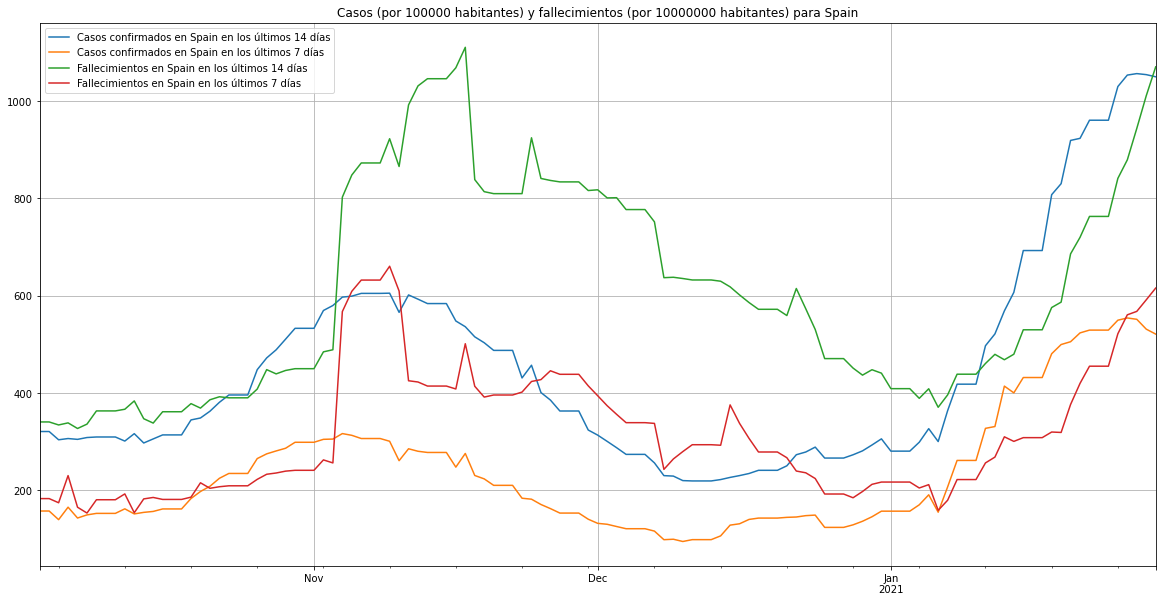

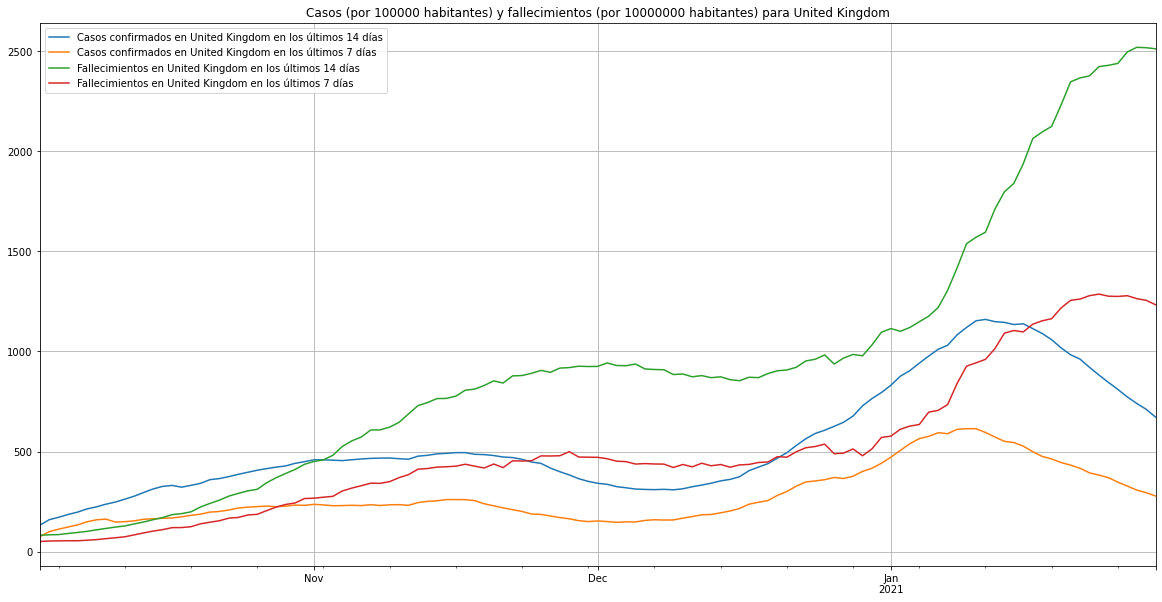

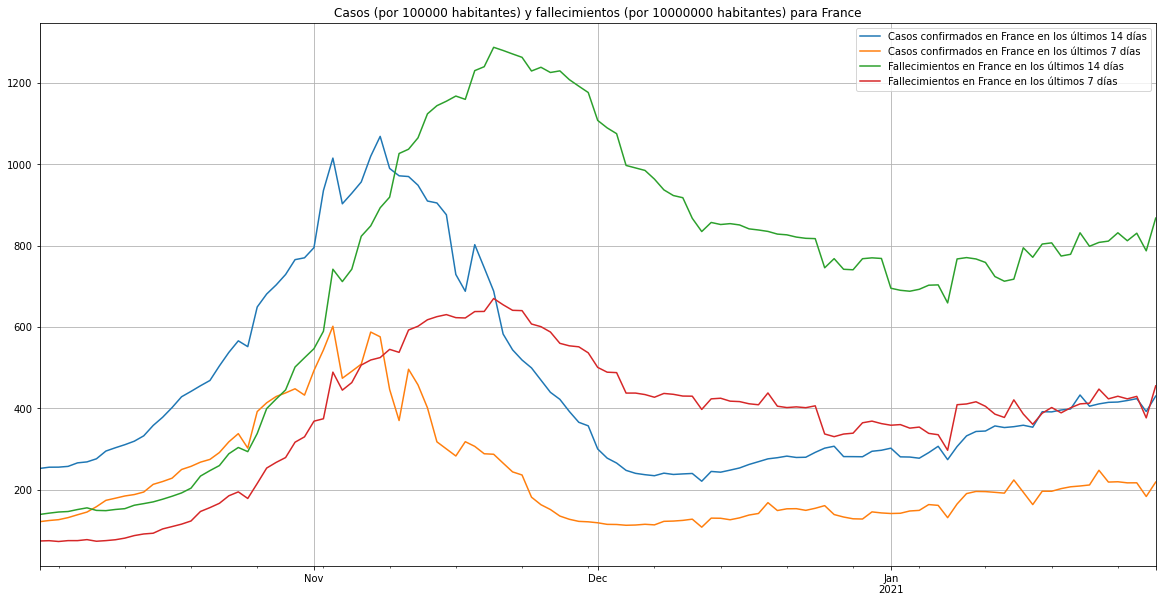

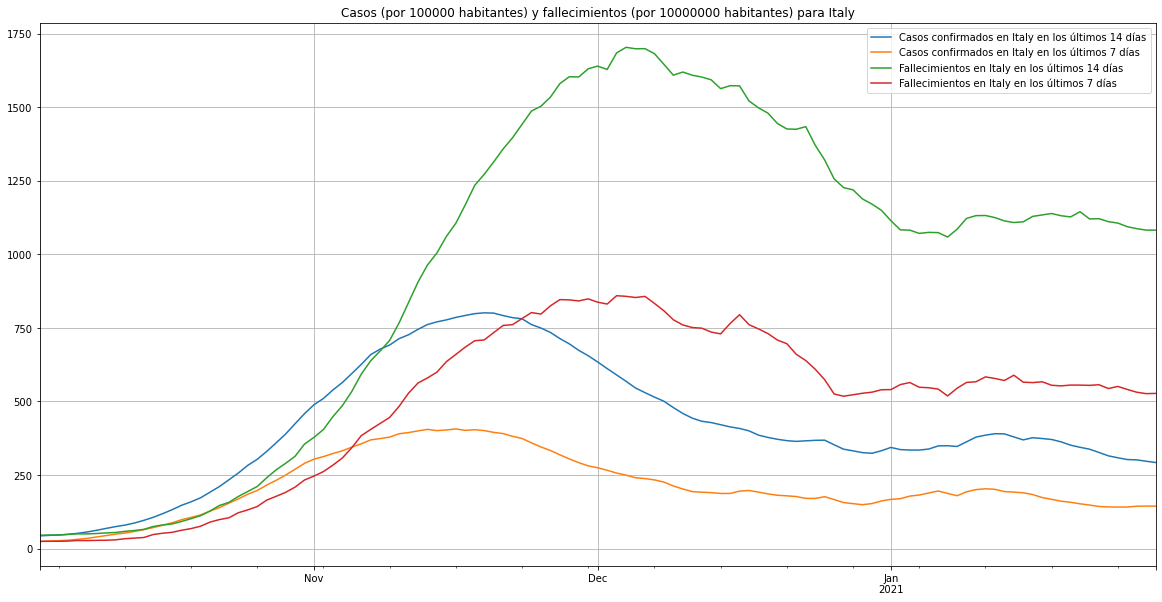

In [37]:
for ic in interesting_countries:
    country_df = pd.DataFrame()
    country_df['Casos confirmados en {} en los últimos {} días'.format(ic,str(confirmed_window))] = cw_df[ic]
    country_df['Casos confirmados en {} en los últimos {} días'.format(ic,str(int(confirmed_window/2)))] = cw2_df[ic]
    country_df['Fallecimientos en {} en los últimos {} días'.format(ic,str(confirmed_window))] = dw_df[ic]
    country_df['Fallecimientos en {} en los últimos {} días'.format(ic,str(int(confirmed_window/2)))] = dw2_df[ic]
    country_df[fromdate:todate].plot(
                   title='Casos (por {} habitantes) y fallecimientos (por {} habitantes) para {}'.format(confirmed_factor, deaths_factor, ic), 
                                               figsize=fsize, 
                                               logy=logaritmic,
                                               grid=True
                                              )

